In [1]:
%matplotlib inline
import os
import json
import pandas
from collections import namedtuple
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
plt.style.use('../style/style-formal.mplstyle')

In [3]:
def calc_afl_perf_from_json(json_path, reproduced_bugs=None, ks=[1, 2, 3, 4, 5]):
    with open(json_path) as f:
        results = json.load(f)
    bug2min_afl_rank = dict()
    for bug_name in results['buggy_methods']:
        if len(results['buggy_methods'][bug_name]) == 0:
            continue
        if reproduced_bugs is not None and bug_name not in reproduced_bugs:
            continue
        min_afl_rank = min([v['autofl_rank'] for method_name, v
                            in results['buggy_methods'][bug_name].items()])
        bug2min_afl_rank[bug_name] = min_afl_rank
    
    afl_perf = [
        len([v for bug_name, v in bug2min_afl_rank.items() if (v<=k)])
        for k in ks
    ]
    return afl_perf

def get_dir_func_calls(data_dir, reproduced_bugs=None):
    result_list = []
    for fname in sorted(os.listdir(data_dir)):
        if os.path.isdir(os.path.join(data_dir, fname)):
            continue
        with open(os.path.join(data_dir, fname)) as f:
            run_info = json.load(f)
        bug_name = fname.removeprefix('XFL-').removesuffix('.json')
        if reproduced_bugs is not None and bug_name not in reproduced_bugs:
            continue
        inf_length = len([e for e in run_info['messages'] if e['role'] == 'assistant'])-1
        func_call_sequence = '-'.join([e['name'] for e in run_info['messages'] if e['role'] == 'function'])
        assert len(func_call_sequence) > 0
        
        result_list.append({
            'inf_length': inf_length,
            'bug_name': bug_name,
            'project': bug_name.split('_')[0],
            'func_calls': func_call_sequence,
        })
    return pandas.DataFrame(result_list)

In [4]:
TechInfo = namedtuple('TechInfo', ('acck', 'type'))
zou_tech_info_ordinal = {
    1: {
        'Metallaxis': TechInfo(106, 'MBFL'),
        'Ochiai': TechInfo(122, 'SBFL'),
        'DStar': TechInfo(125, 'SBFL'),
        'AutoFL': TechInfo(145, 'LLM-Based'),
    },
    2: {
        'Metallaxis': TechInfo(143, 'MBFL'),
        'Ochiai': TechInfo(164, 'SBFL'),
        'DStar': TechInfo(166, 'SBFL'),
    },
    3: {
        'Metallaxis': TechInfo(162, 'MBFL'),
        'Ochiai': TechInfo(192, 'SBFL'),
        'DStar': TechInfo(195, 'SBFL'),
        'AutoFL': TechInfo(182, 'LLM-Based'),
    },
    4: {
        'Metallaxis': TechInfo(180, 'MBFL'),
        'Ochiai': TechInfo(211, 'SBFL'),
        'DStar': TechInfo(209, 'SBFL'),
    },
    5: {
        'Metallaxis': TechInfo(191, 'MBFL'),
        'Ochiai': TechInfo(218, 'SBFL'),
        'DStar': TechInfo(216, 'SBFL'),
        'AutoFL': TechInfo(200, 'LLM-Based'),
    },
    10: {
        'Metallaxis': TechInfo(223, 'MBFL'),
        'Ochiai': TechInfo(250, 'SBFL'),
        'DStar': TechInfo(252, 'SBFL'),
        'AutoFL': TechInfo(200, 'LLM-Based'),
    },
}

/var/folders/2k/8wzh_94n6j343ft6rmt_hy4w0000gn/T/ipykernel_98384/2482653781.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(xs, ys, 'x-', label=tech_name, color='#333',


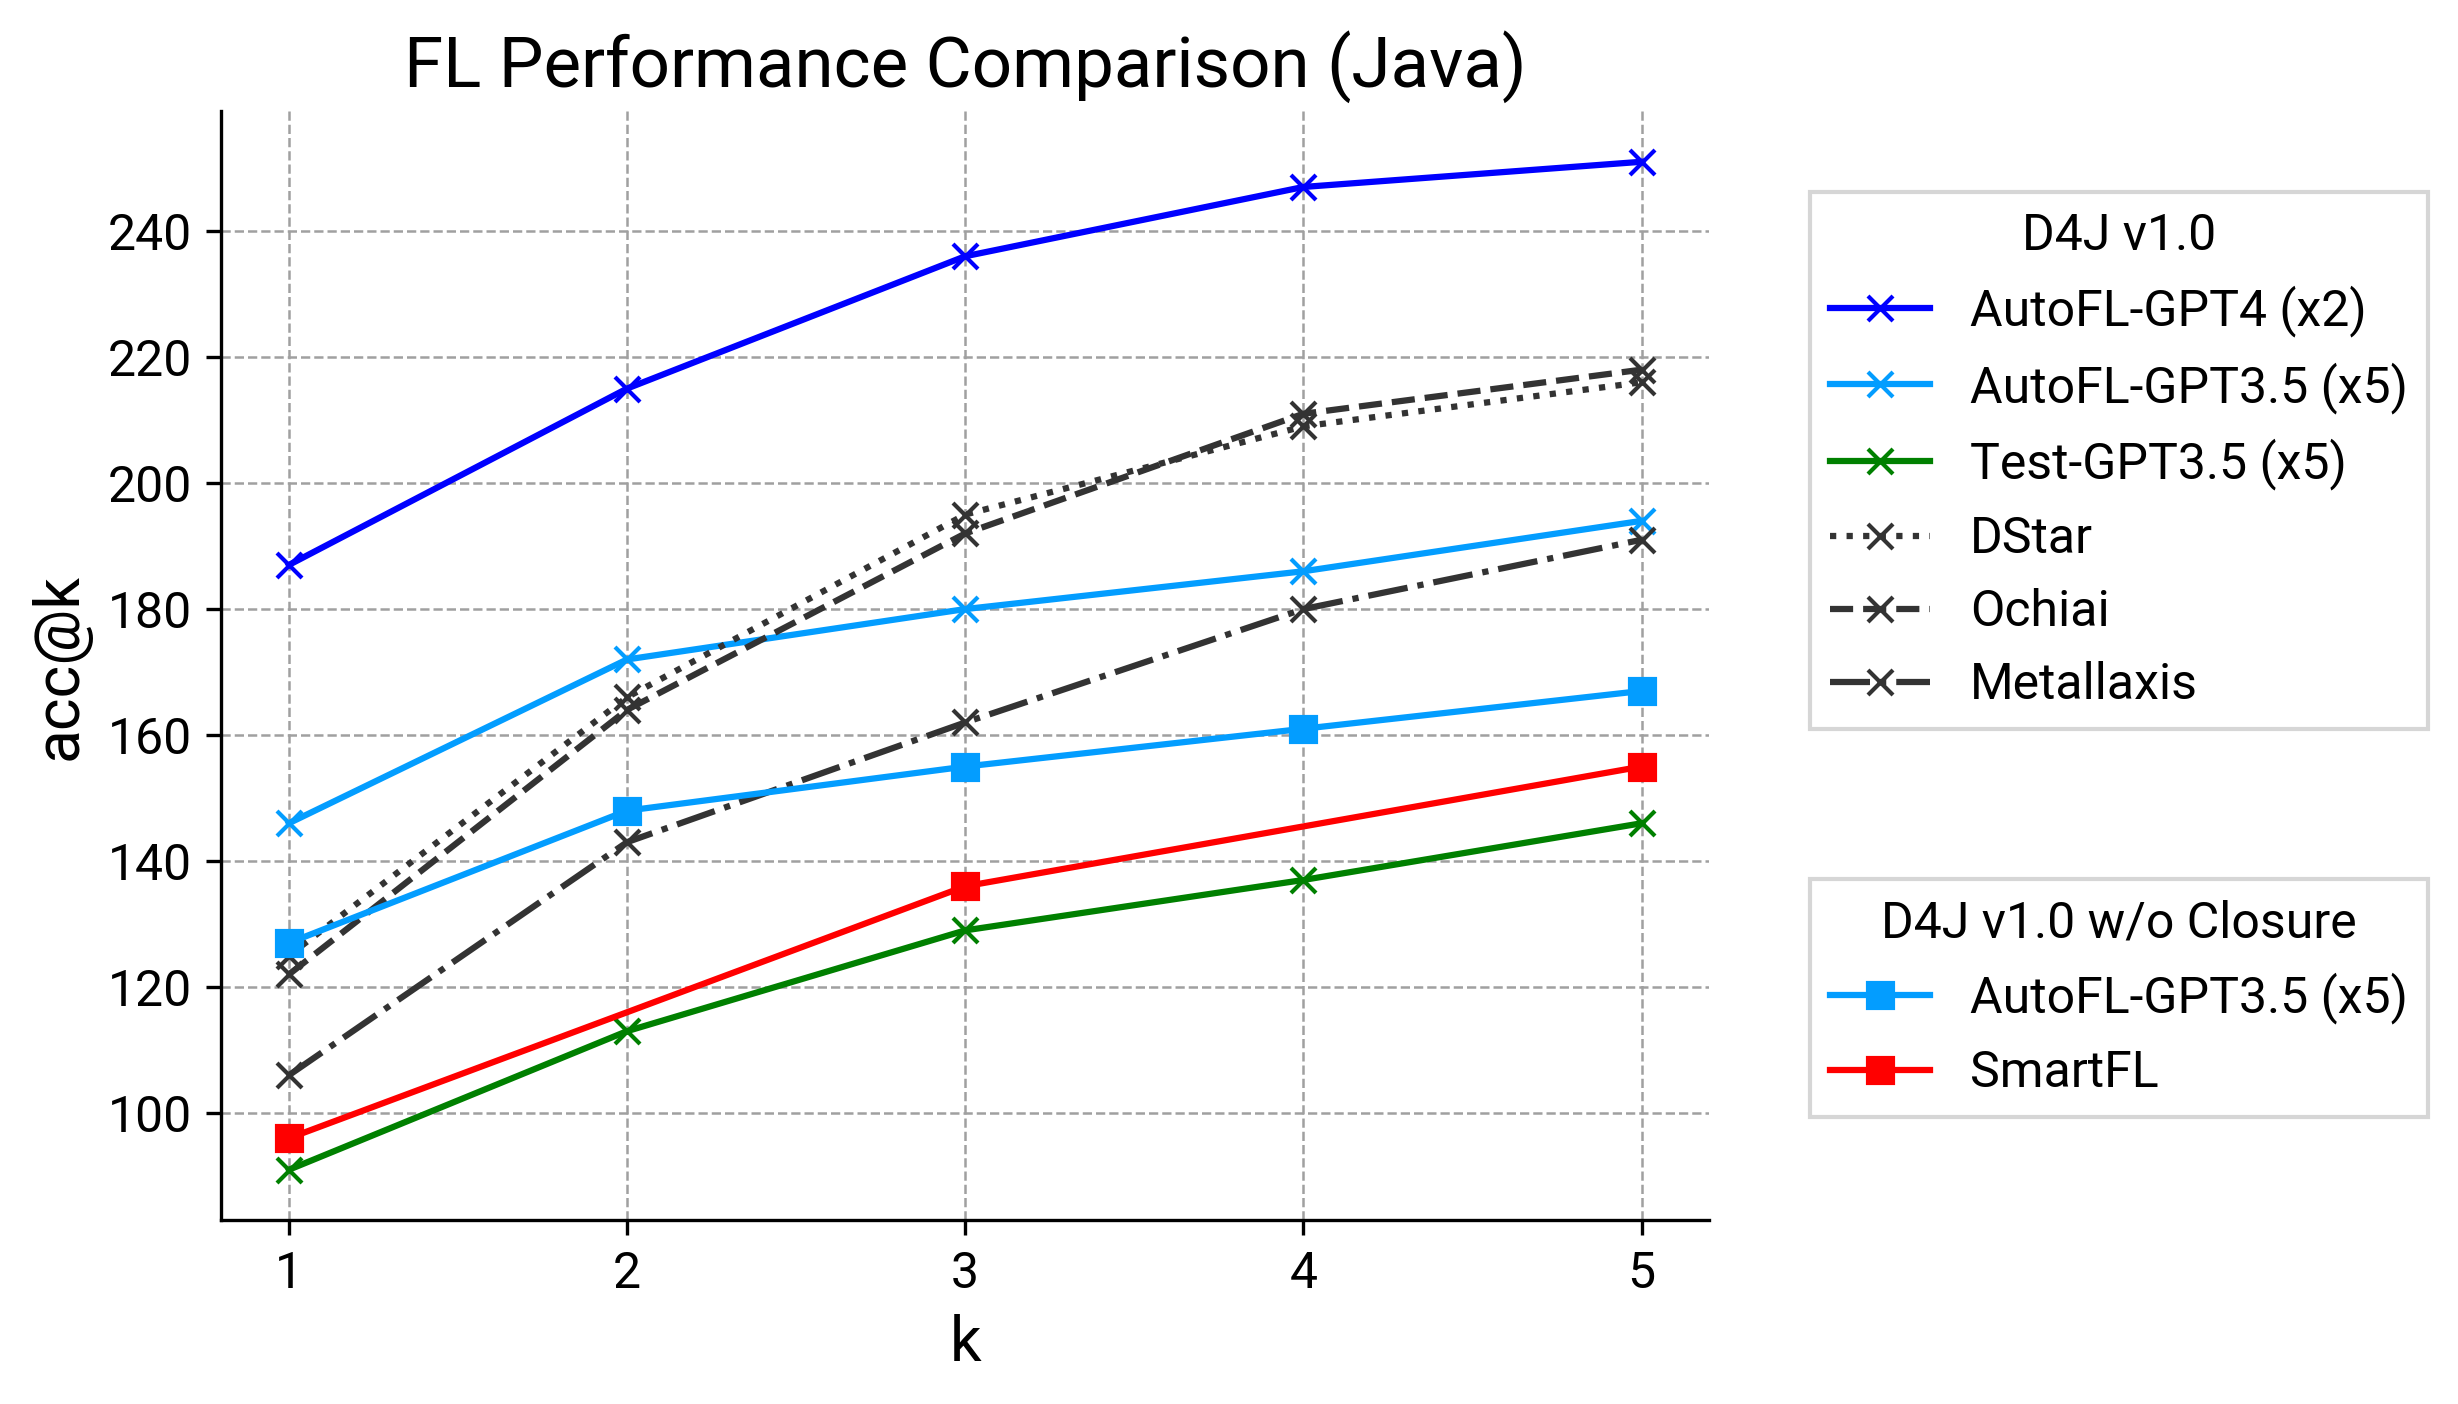

In [5]:
linestyles = ['dashdot', 'dashed', 'dotted']
target_baselines = ['Metallaxis', 'Ochiai', 'DStar']

plt.plot(range(1, 6), calc_afl_perf_from_json('../combined_fl_results/d4j_gpt4_results_R2.json'), 
         'x-', color='blue', label='AutoFL-GPT4 (x2)')
plt.plot(range(1, 6), calc_afl_perf_from_json('../combined_fl_results/d4j_gpt3_results_R5.json'), 
         'x-', label='AutoFL-GPT3.5 (x5)')
plt.plot(range(1, 6), calc_afl_perf_from_json('../combined_fl_results/d4j_llmtest_results.json'), 
         'x-', color='green', label='Test-GPT3.5 (x5)')

for tech_name in target_baselines[::-1]:
    if tech_name not in target_baselines:
        continue
    else:
        tech_index = target_baselines.index(tech_name)
    xs, ys = [], []
    for k in zou_tech_info_ordinal:
        if tech_name not in zou_tech_info_ordinal[k]:
            continue
        if k > 5:
            continue
        xs.append(k)
        ys.append(zou_tech_info_ordinal[k][tech_name].acck)
    plt.plot(xs, ys, 'x-', label=tech_name, color='#333',
             linestyle=linestyles[tech_index] if tech_name!='AutoFL' else None)

legend1 = plt.legend(bbox_to_anchor=(1.5, 0.95), fontsize=12, title='D4J v1.0', title_fontsize=12)
    
l1, = plt.plot([1, 2, 3, 4, 5], [127, 148, 155, 161, 167], 's-', color='#039dff', label='AutoFL-GPT3.5 (x5)')
l2, = plt.plot([1, 3, 5], [96, 136, 155], 's-', color='red', label='SmartFL')

plt.legend([l1, l2], ['AutoFL-GPT3.5 (x5)', 'SmartFL'],
    bbox_to_anchor=(1.5, 0.33), fontsize=12, title='D4J v1.0 w/o Closure', title_fontsize=12)
plt.gca().add_artist(legend1)

plt.xlabel('k', fontsize=15)
plt.ylabel('acc@k', fontsize=15)
plt.xticks(range(1, 6), fontsize=12)
plt.yticks(fontsize=12)
plt.title('FL Performance Comparison (Java)', fontsize=17)
plt.savefig('figures/RQ1_FLperf_Java.pdf', bbox_inches='tight')

/var/folders/2k/8wzh_94n6j343ft6rmt_hy4w0000gn/T/ipykernel_98384/1357338761.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  temp_color = mpl.cm.get_cmap('coolwarm')(r/max(r2perf.keys()))
/var/folders/2k/8wzh_94n6j343ft6rmt_hy4w0000gn/T/ipykernel_98384/1357338761.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  temp_color = mpl.cm.get_cmap('coolwarm')((reruns-(1 if reruns == 1 else -1))/max(gpt4_r2perf.keys()))


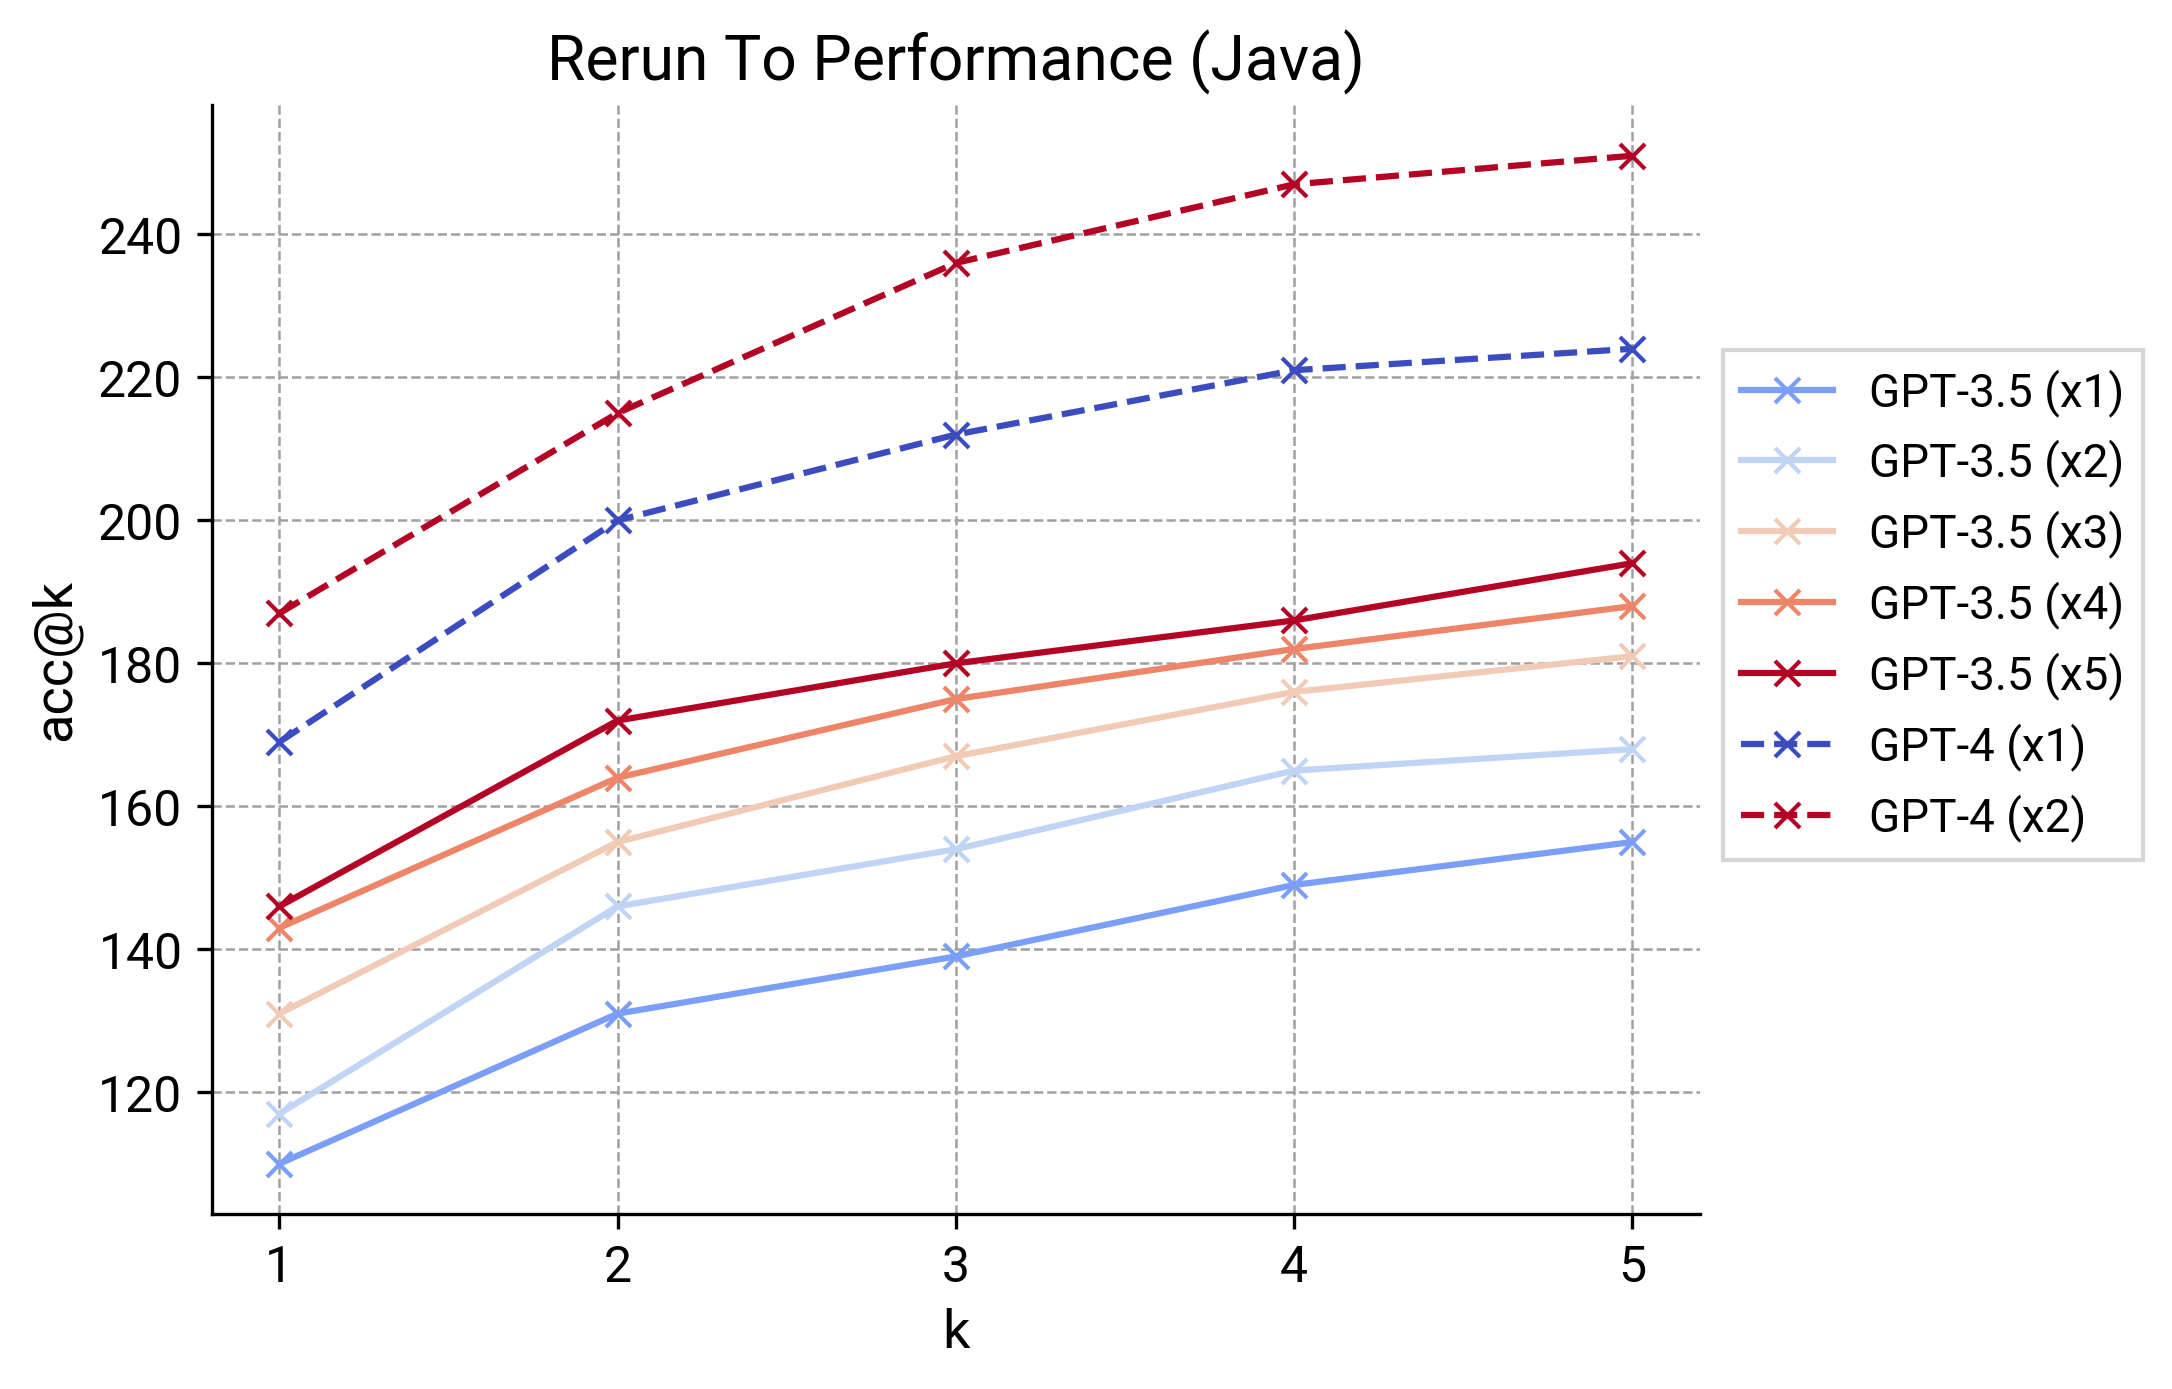

In [6]:
r2perf = {
    r: calc_afl_perf_from_json(f'../combined_fl_results/d4j_gpt3_results_R{r}.json')
    for r in range(1, 6)
}
gpt4_r2perf = {
    r: calc_afl_perf_from_json(f'../combined_fl_results/d4j_gpt4_results_R{r}.json')
    for r in range(1, 3)
}
for r, accks in r2perf.items():
    temp_color = mpl.cm.get_cmap('coolwarm')(r/max(r2perf.keys()))
    plt.plot(range(1, 6), accks, 'x-', color=temp_color, label=f'GPT-3.5 (x{r})')
for reruns, acc_list in gpt4_r2perf.items():
    temp_color = mpl.cm.get_cmap('coolwarm')((reruns-(1 if reruns == 1 else -1))/max(gpt4_r2perf.keys()))
    plt.plot(range(1, 6), acc_list[:5], 'x--', color=temp_color, label=f'GPT-4 (x{reruns})')
    
plt.legend(bbox_to_anchor=(1, 0.8), fontsize=11)
plt.title('Rerun To Performance (Java)', fontsize=15)
plt.xlabel('k', fontsize=13)
plt.ylabel('acc@k', fontsize=13)
plt.xticks(range(1, 6), fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('figures/RQ1_rerun_performance_java.pdf', bbox_inches='tight')

In [7]:
no_error_msg = [
    'black_21',
    'tqdm_1',
    'tqdm_2',
    'tqdm_3',
    'tqdm_4',
    'tqdm_5',
    'tqdm_6',
    'tqdm_7',
    'tqdm_8',
    'tqdm_9',
    'spacy_4',
    'ansible_8',
    'ansible_13',
    'sanic_2'
]
no_failing_test = [
    'ansible_12', 
    'keras_12', 
    'keras_29', 
    'keras_45', 
    'keras_9', 
    'pandas_5', 
    'scrapy_13', 
    'scrapy_20', 
    'tornado_11', 
    'tornado_3', 
    'youtube-dl_16'
]
problematic_bugs = set(no_error_msg) | set(no_failing_test)

In [8]:
reprod_df = pandas.read_csv('resources/bip_reproduction.csv', header=None)
bug2reproduced = dict()
for r_idx, row in reprod_df.iterrows():
    bug_name = row[0]+'_'+str(row[1])
    if bug_name not in bug2reproduced:
        assert row[2] == 'buggy', bug_name
        bug2reproduced[bug_name] = {
            'failed_in_buggy': row[3] != 'error',
            'fully_reproduced': False,
        }
    else:
        assert row[2] == 'fixed', bug_name
        bug2reproduced[bug_name]['fully_reproduced'] = (
            bug2reproduced[bug_name]['failed_in_buggy']
            and bug_name not in problematic_bugs
        )

print('total bugs in BIP:', len(bug2reproduced))
reproduced_bugs = set([e for e, v in bug2reproduced.items() if v['fully_reproduced']])
print('reproduced bugs in BIP:', len(reproduced_bugs))

total bugs in BIP: 501
reproduced bugs in BIP: 445


In [9]:
# get SBFL performance
DATA_DIR = '../data/bugsinpy'
KEYS = [
    'pseudo_ochiai_susp',
    'pseudo_dstar_susp',
]
all_rank_info = []
for bug_name in sorted(os.listdir(DATA_DIR)):
    if not bug2reproduced[bug_name]['fully_reproduced']:
        continue
    with open(os.path.join(DATA_DIR, bug_name, 'snippet.json')) as f:
        bug_snip_infos = json.load(f)
    target_bug_info = {'bug_name': bug_name, 'project': bug_name.split('_')[0]}
    for key in KEYS:
        key_method_ranks = rankdata([-snip_info['susp'][key] for snip_info in bug_snip_infos],
                                    method='ordinal')
        rank_with_label = list(zip(key_method_ranks, [e['is_bug'] for e in bug_snip_infos]))
        if not any(is_bug for _, is_bug in rank_with_label):
            continue
        target_bug_info[key.replace('_susp', '_rank')] = [rank for rank, is_bug in rank_with_label if is_bug][0]
    if not any(k.replace('_susp', '_rank') in target_bug_info for k in KEYS):
        continue
    all_rank_info.append(target_bug_info)
all_rank_df = pandas.DataFrame(all_rank_info)

ochiai_perf = []
dstar_perf = []
for key in KEYS:
    for k in [1, 2, 3, 4, 5]:
        acck = (all_rank_df[key.replace('_susp', '_rank')] <= k).sum()
#         print(f'acc@{k} = {acck}')
        if key == 'pseudo_ochiai_susp':
            ochiai_perf.append(acck)
        elif key == 'pseudo_dstar_susp':
            dstar_perf.append(acck)
print(ochiai_perf)
print(dstar_perf)

[63, 92, 114, 128, 143]
[43, 68, 81, 87, 96]


/var/folders/2k/8wzh_94n6j343ft6rmt_hy4w0000gn/T/ipykernel_98384/2509278710.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([1, 2, 3, 4, 5], dstar_perf, 'x-', ls='dotted', color='#333', label='DStar')
/var/folders/2k/8wzh_94n6j343ft6rmt_hy4w0000gn/T/ipykernel_98384/2509278710.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([1, 2, 3, 4, 5], ochiai_perf, 'x-', ls='dashed', color='#333', label='Ochiai')


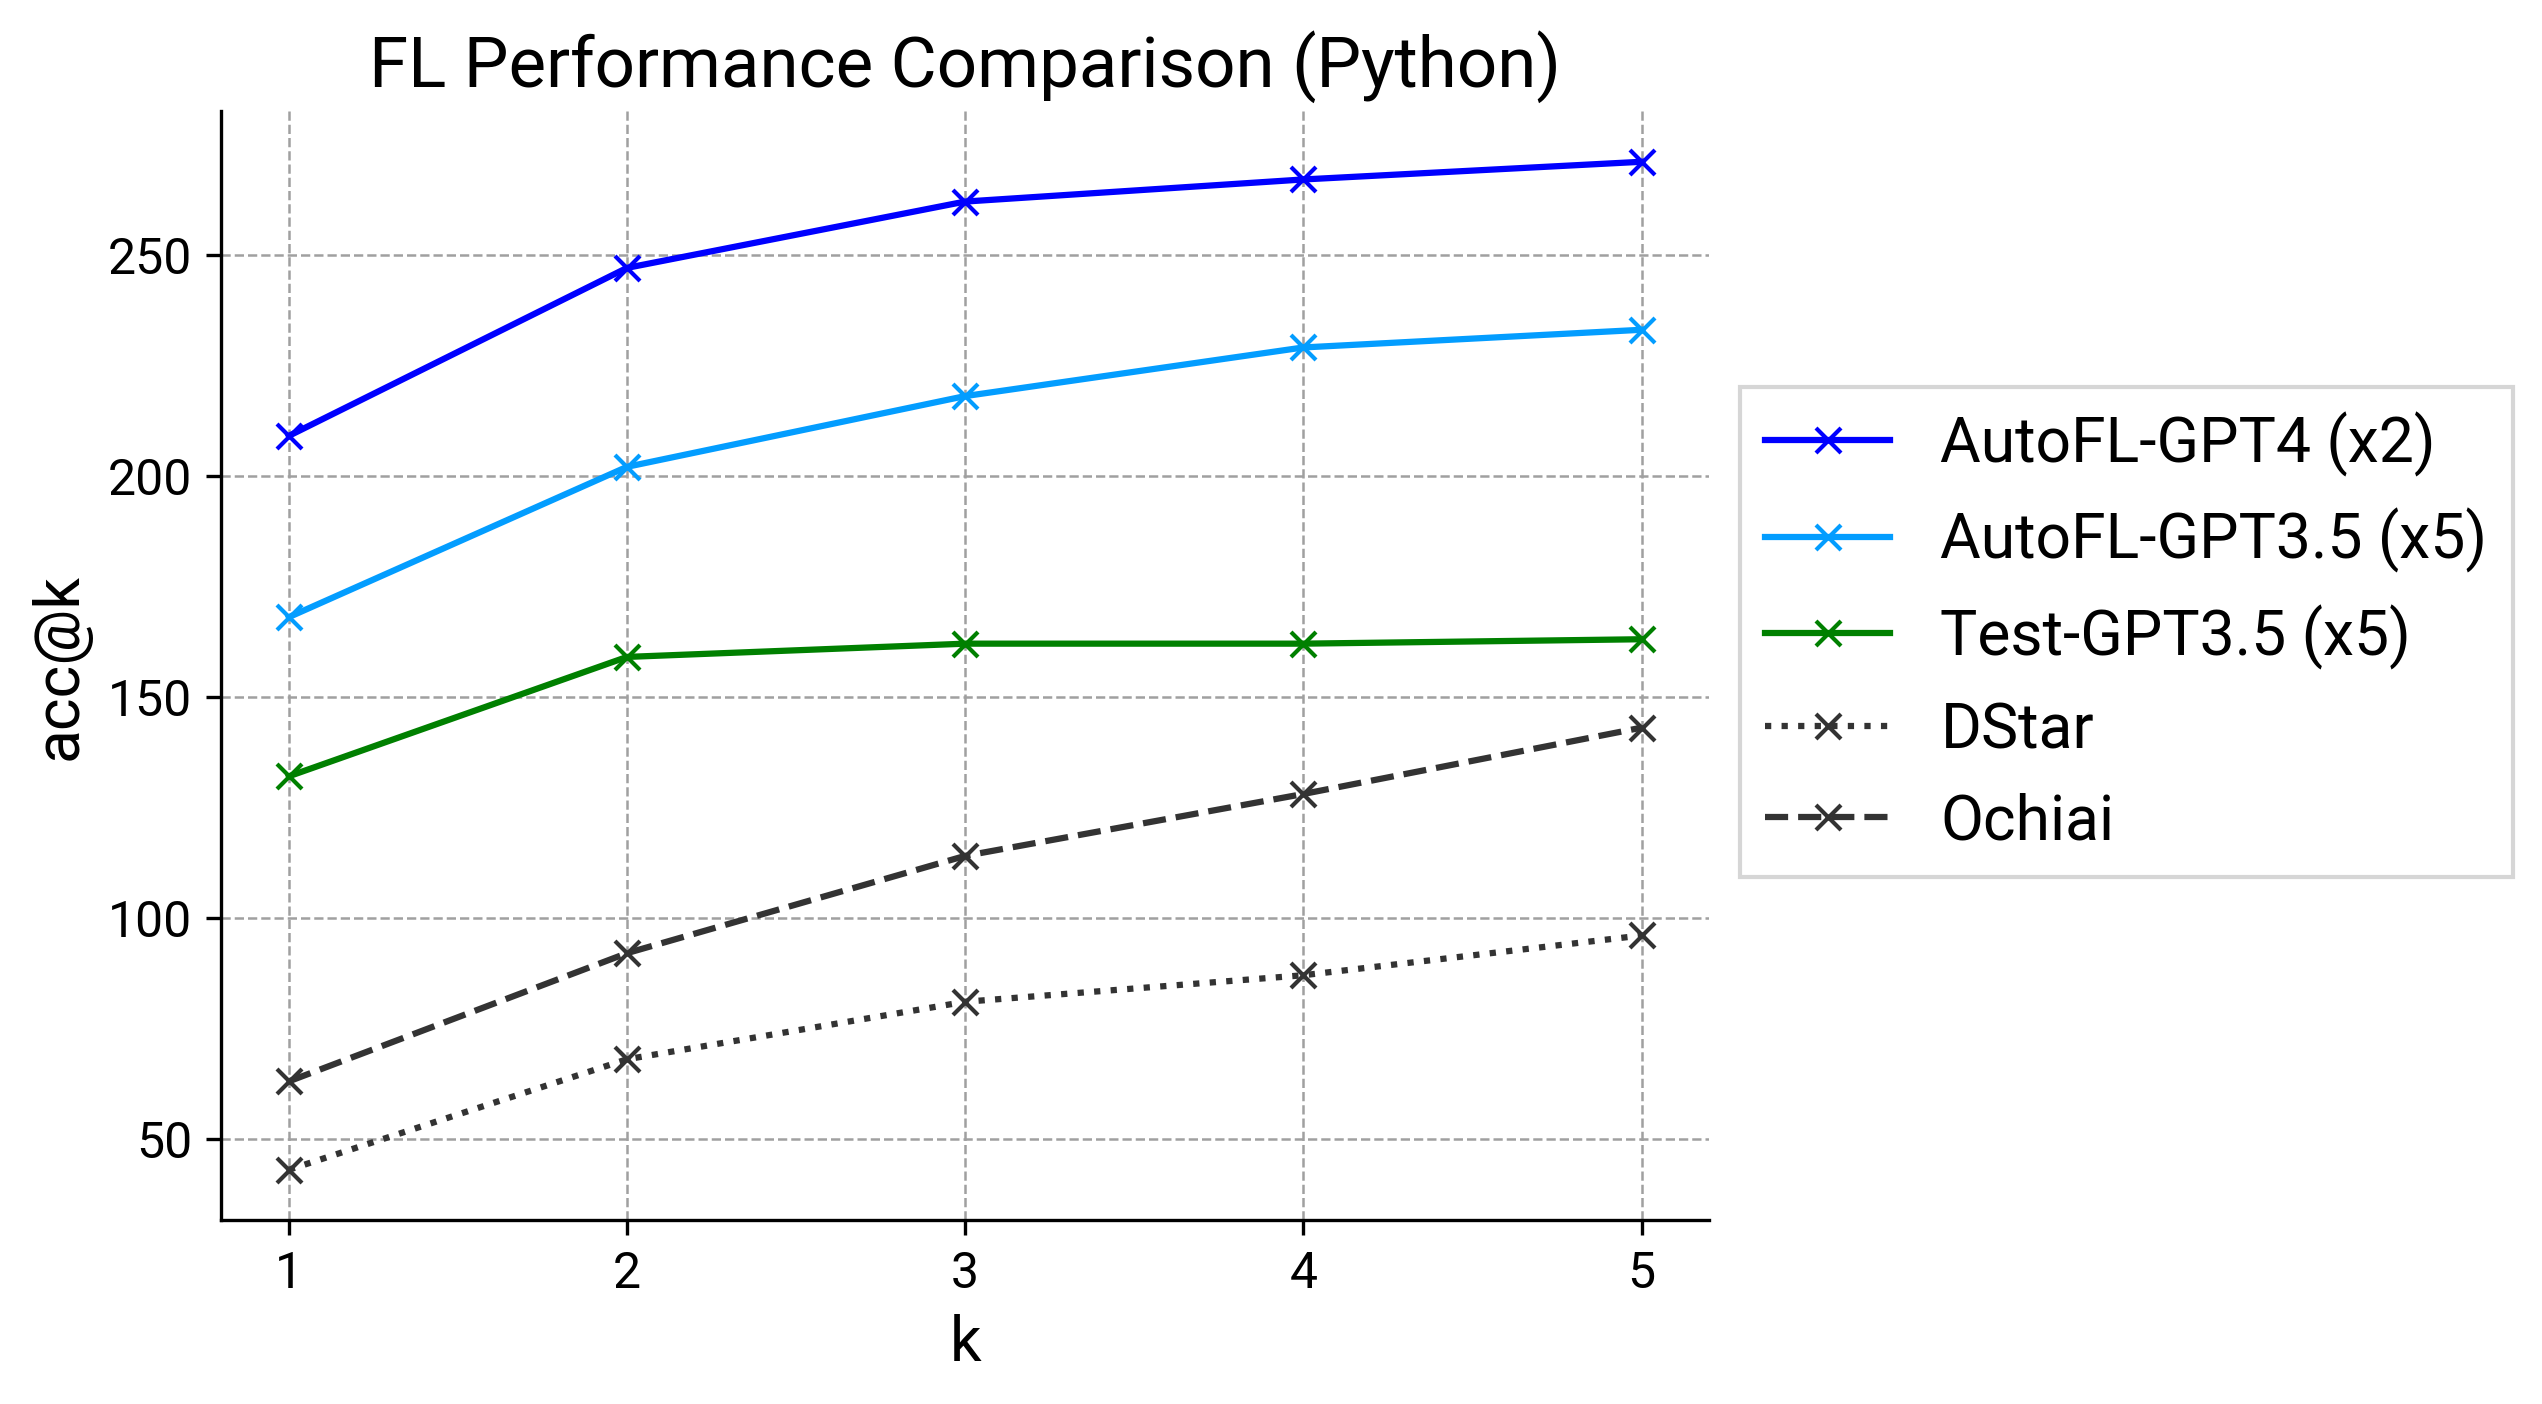

In [10]:
plt.plot(range(1, 6), calc_afl_perf_from_json('../combined_fl_results/bip_gpt4_results_R2.json', reproduced_bugs), 
         'x-', color='blue', label='AutoFL-GPT4 (x2)')
plt.plot(range(1, 6), calc_afl_perf_from_json('../combined_fl_results/bip_gpt3_results_R5.json', reproduced_bugs), 
         'x-', label='AutoFL-GPT3.5 (x5)')
plt.plot(range(1, 6), calc_afl_perf_from_json('../combined_fl_results/bip_llmtest_results.json', reproduced_bugs),
         'x-', color='green', label='Test-GPT3.5 (x5)')
plt.plot([1, 2, 3, 4, 5], dstar_perf, 'x-', ls='dotted', color='#333', label='DStar')
plt.plot([1, 2, 3, 4, 5], ochiai_perf, 'x-', ls='dashed', color='#333', label='Ochiai')
plt.legend(bbox_to_anchor=(1.0, 0.78), fontsize=15)
plt.xlabel('k', fontsize=15)
plt.ylabel('acc@k', fontsize=15)
plt.xticks(range(1, 6), fontsize=12)
plt.yticks(fontsize=12)
plt.title('FL Performance Comparison (Python)', fontsize=17)
plt.savefig('figures/RQ1_FLperf_Python.pdf', bbox_inches='tight')

/var/folders/2k/8wzh_94n6j343ft6rmt_hy4w0000gn/T/ipykernel_98384/2056032591.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  temp_color = mpl.cm.get_cmap('coolwarm')(r/max(r2perf.keys()))
/var/folders/2k/8wzh_94n6j343ft6rmt_hy4w0000gn/T/ipykernel_98384/2056032591.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  temp_color = mpl.cm.get_cmap('coolwarm')((reruns-(1 if reruns == 1 else -1))/max(gpt4_r2perf.keys()))


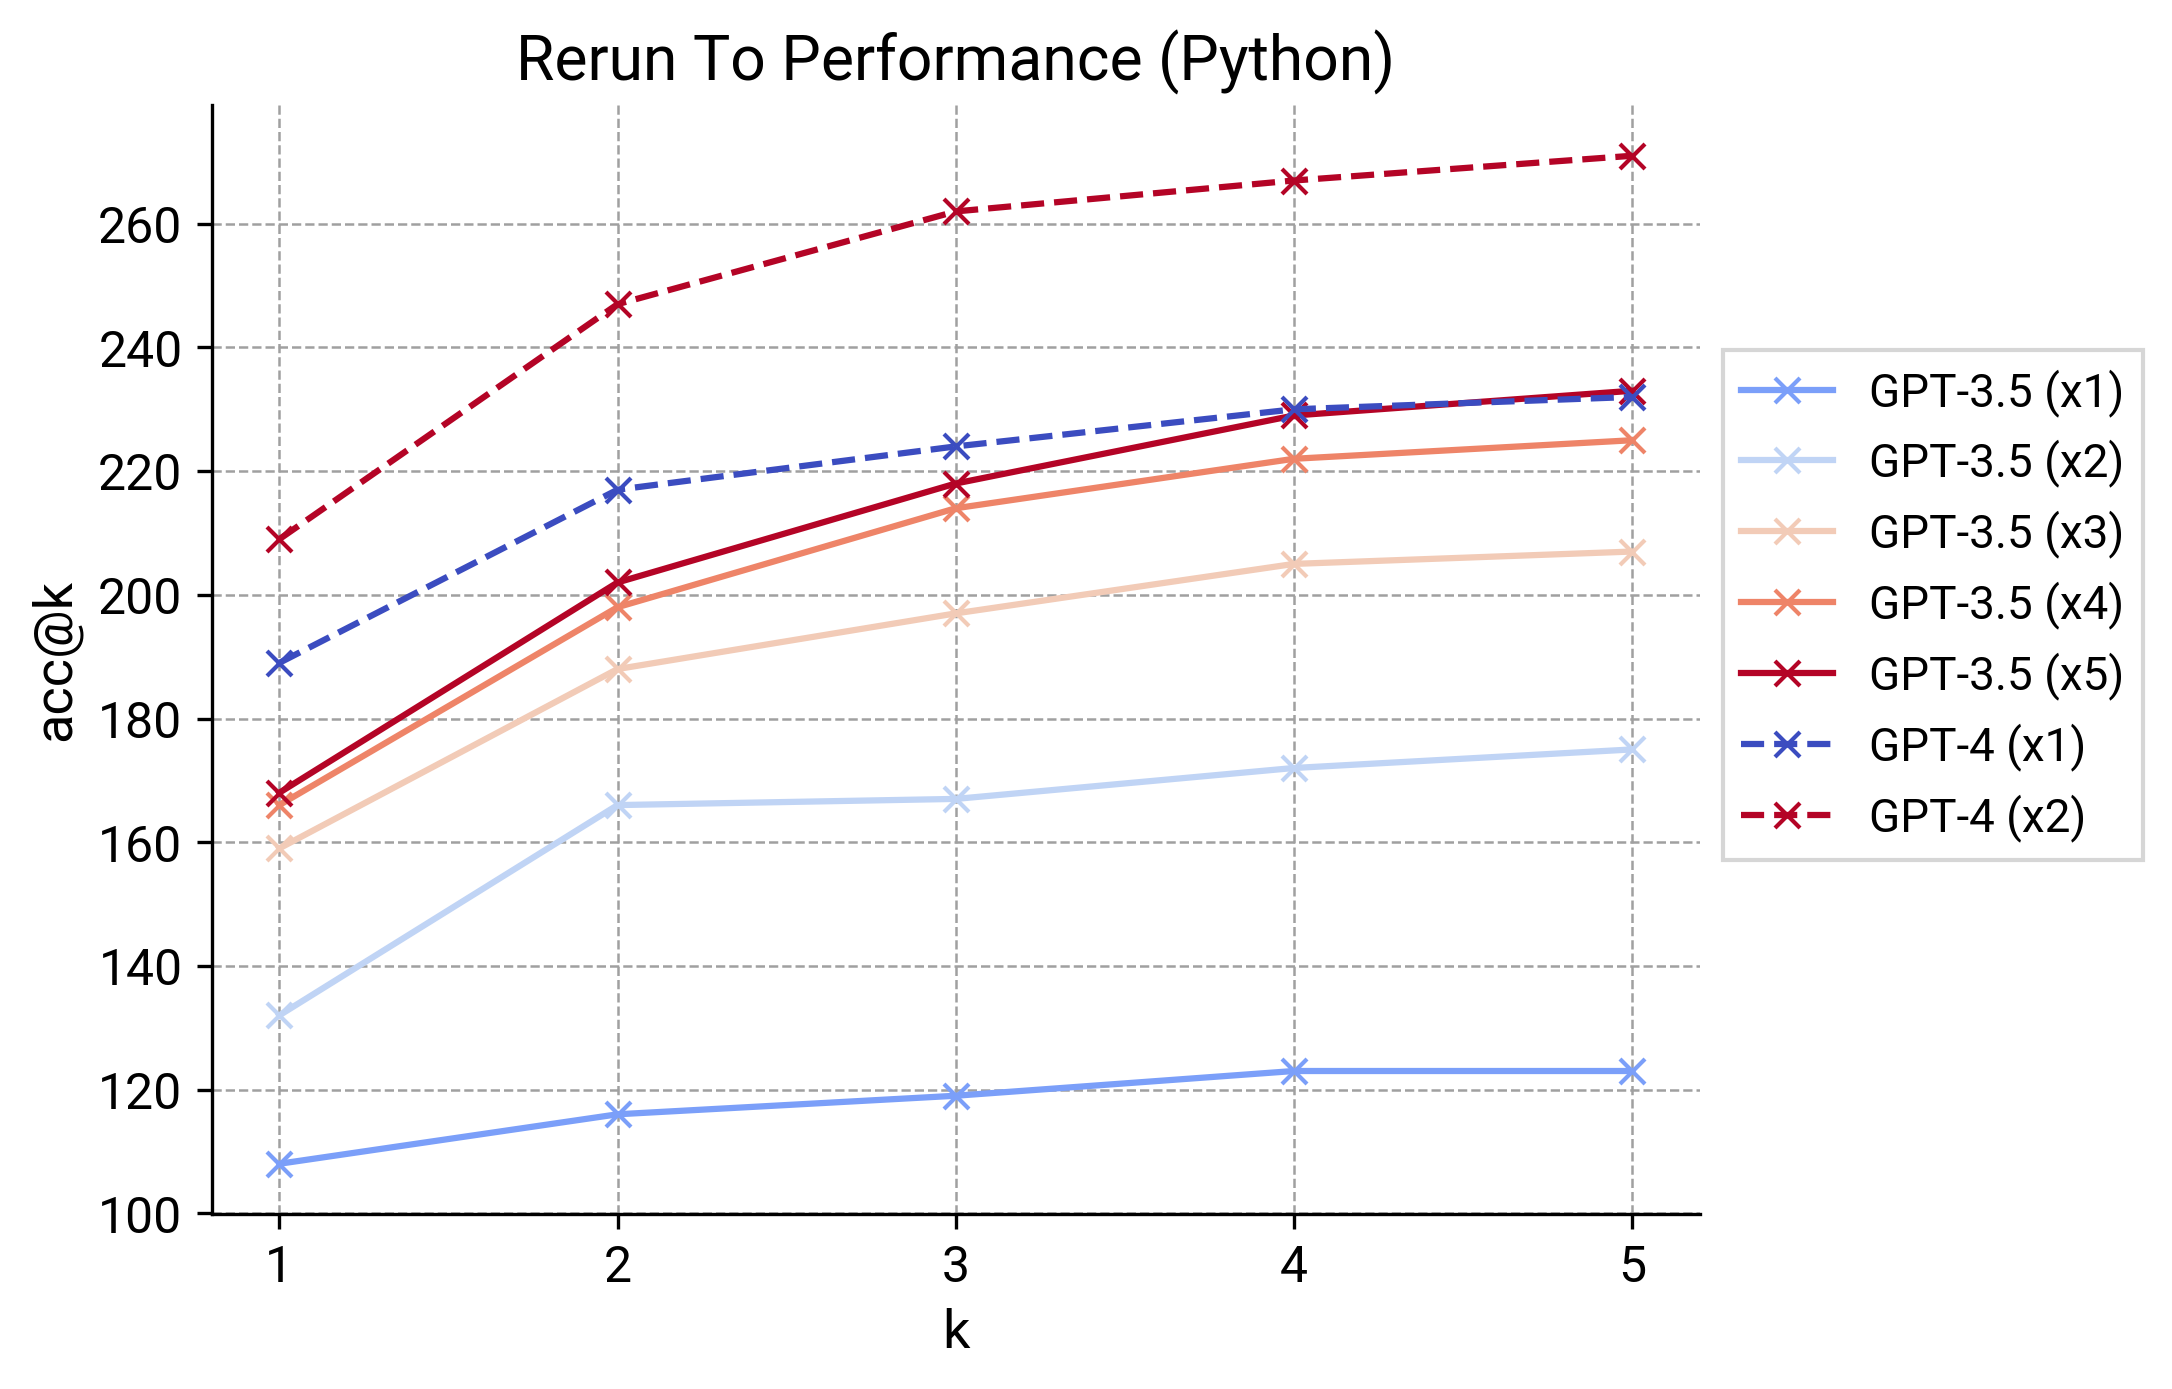

In [11]:
r2perf = {
    r: calc_afl_perf_from_json(f'../combined_fl_results/bip_gpt3_results_R{r}.json', reproduced_bugs)
    for r in range(1, 6)
}
gpt4_r2perf = {
    r: calc_afl_perf_from_json(f'../combined_fl_results/bip_gpt4_results_R{r}.json', reproduced_bugs)
    for r in range(1, 3)
}
for r, accks in r2perf.items():
    temp_color = mpl.cm.get_cmap('coolwarm')(r/max(r2perf.keys()))
    plt.plot(range(1, 6), accks, 'x-', color=temp_color, label=f'GPT-3.5 (x{r})')
for reruns, acc_list in gpt4_r2perf.items():
    temp_color = mpl.cm.get_cmap('coolwarm')((reruns-(1 if reruns == 1 else -1))/max(gpt4_r2perf.keys()))
    plt.plot(range(1, 6), acc_list[:5], 'x--', color=temp_color, label=f'GPT-4 (x{reruns})')
    
plt.legend(bbox_to_anchor=(1, 0.8), fontsize=11)
plt.title('Rerun To Performance (Python)', fontsize=15)
plt.xlabel('k', fontsize=13)
plt.ylabel('acc@k', fontsize=13)
plt.xticks(range(1, 6), fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('figures/RQ1_rerun_performance_python.pdf', bbox_inches='tight')

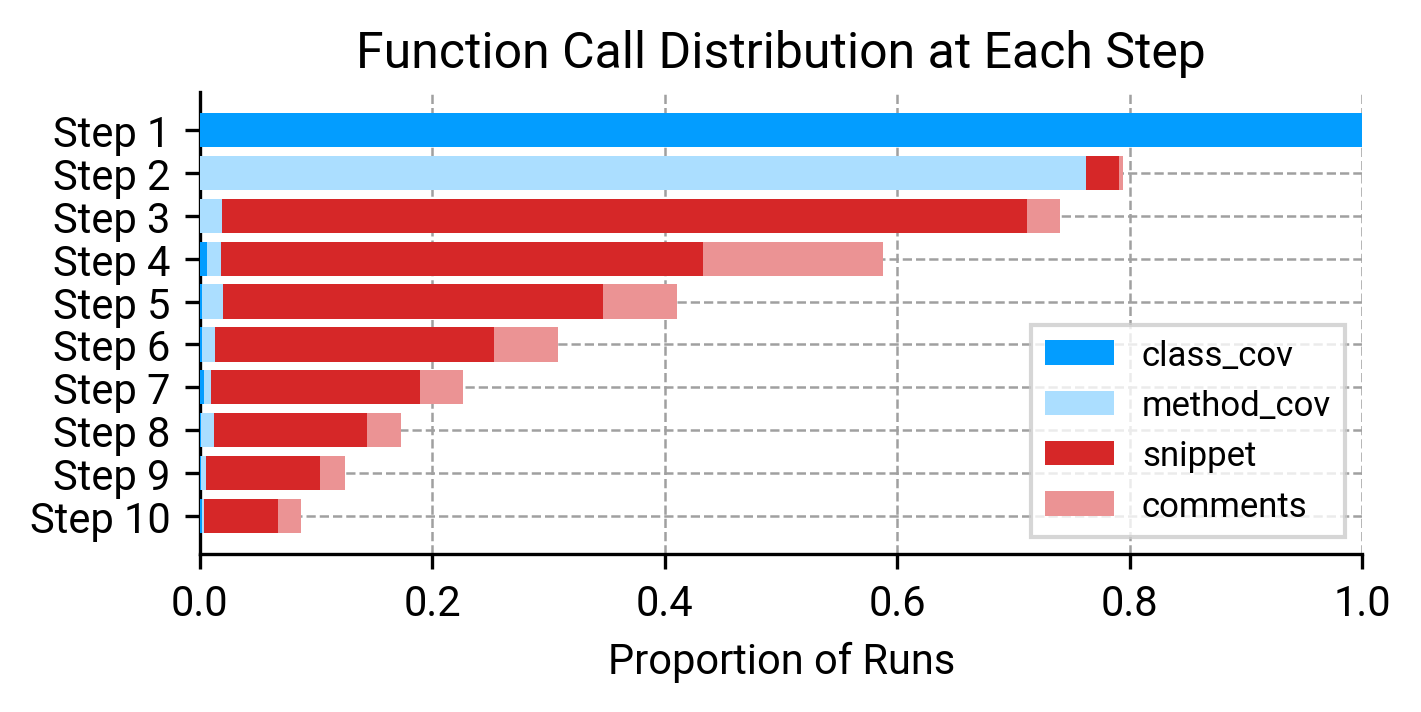

In [12]:
merge_data_template = '../results/d4j_autofl_%d/gpt-3.5-turbo-0613/'
merge_dfs = [get_dir_func_calls(merge_data_template%i) for i in range(1, 6)]
total_runs = 353*5

plt.rcParams['figure.figsize'] = [5, 2]
yrange = range(9, -1, -1)
curr_sums = [0 for _ in range(10)]
func_names = ['get_failing_tests_covered_classes', 'get_failing_tests_covered_methods_for_class',
          'get_code_snippet', 'get_comments']
func_labels = ['class_cov', 'method_cov', 'snippet', 'comments']
colors=['039dff', 'ABDEFF', 'd62728', 'EB9394']
for f_idx, func_name in enumerate(func_names):
    stage_counts = [0 for _ in range(10)]
    for result_df in merge_dfs:
        for _, row in result_df[result_df.project != 'Mockito'].iterrows():
            func_call_seq = row.func_calls.split('-')
            for idx, call_name in enumerate(func_call_seq):
                if idx > 9:
                    continue
                if func_name == call_name:
                    stage_counts[idx] += 1/total_runs
    plt.barh(yrange, 
             stage_counts, 
             tick_label=[f'Step {i}' for i in range(1, 11)], 
             left=curr_sums, 
             color='#' + colors[f_idx], 
             label=func_labels[f_idx], 
             zorder=3)
    curr_sums = [x+y for x, y in zip(curr_sums, stage_counts)]
plt.legend()
plt.title('Function Call Distribution at Each Step')
plt.xlabel('Proportion of Runs')
plt.savefig('figures/RQ1_func_call_dist.pdf', bbox_inches='tight')

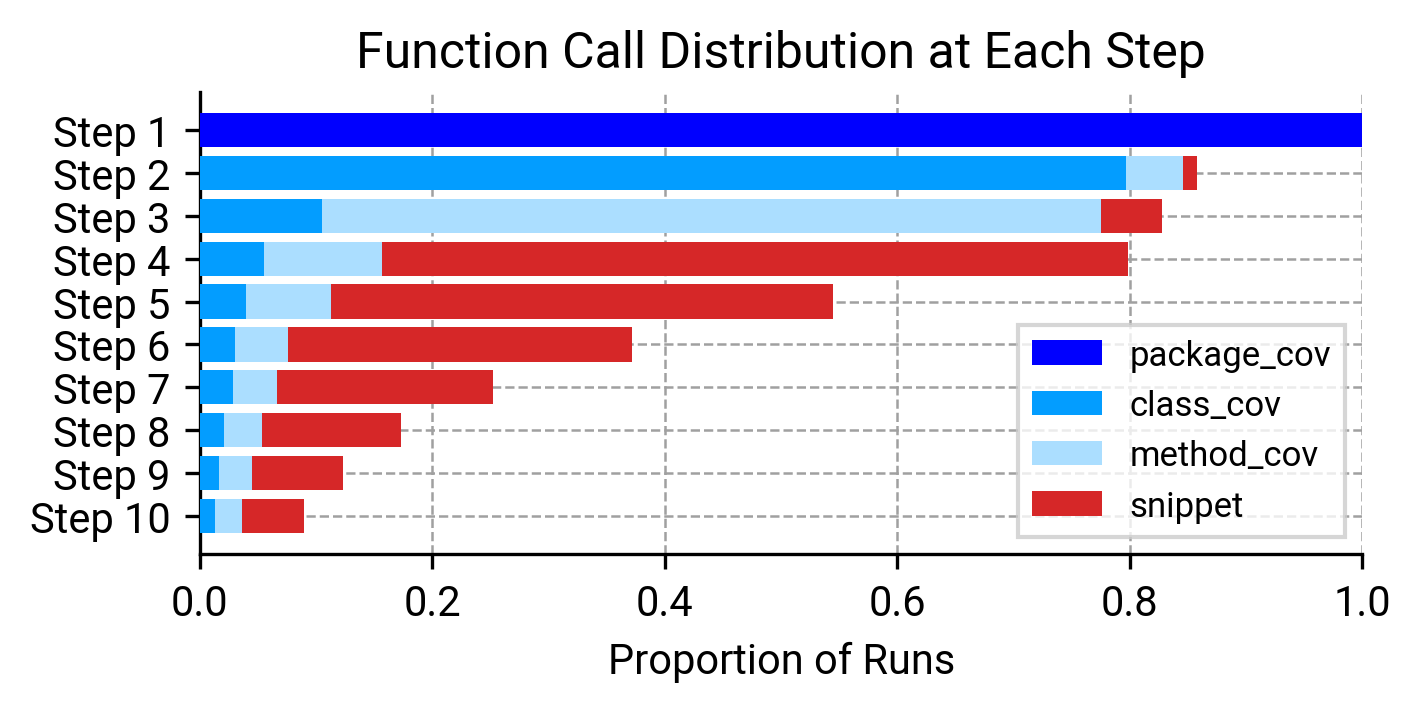

In [13]:
# bip plotting
merge_data_template = '../results/bip_autofl_%d/gpt-3.5-turbo-0613/'
total_runs = len(reproduced_bugs)*5
merge_dfs = [get_dir_func_calls(merge_data_template%i, reproduced_bugs) for i in range(1, 6)]

plt.rcParams['figure.figsize'] = [5, 2]
yrange = range(9, -1, -1)
curr_sums = [0 for _ in range(10)]
func_names = ['get_covered_packages', 'get_failing_tests_covered_classes', 'get_failing_tests_covered_methods_for_class',
          'get_code_snippet']
func_labels = ['package_cov', 'class_cov', 'method_cov', 'snippet']
colors=['0000ff', '039dff', 'ABDEFF', 'd62728', 'EB9394']
for f_idx, func_name in enumerate(func_names):
    stage_counts = [0 for _ in range(10)]
    for result_df in merge_dfs:
        for _, row in result_df[result_df.project != 'Mockito'].iterrows():
            func_call_seq = row.func_calls.split('-')
            for idx, call_name in enumerate(func_call_seq):
                if idx > 9:
                    continue
                if func_name == call_name:
                    stage_counts[idx] += 1/total_runs
    plt.barh(yrange, 
             stage_counts, 
             tick_label=[f'Step {i}' for i in range(1, 11)], 
             left=curr_sums, 
             color='#' + colors[f_idx], 
             label=func_labels[f_idx], 
             zorder=3)
    curr_sums = [x+y for x, y in zip(curr_sums, stage_counts)]
plt.legend()
# plt.xlim(0, 1)
plt.title('Function Call Distribution at Each Step')
plt.xlabel('Proportion of Runs')
plt.savefig('figures/RQ1_func_call_dist_bip.pdf', bbox_inches='tight')